In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from tqdm import tqdm

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
print(os.getcwd())

/home/kimnal0/ChatCoT/early_termination


In [5]:
dataset_F = dict()
dataset_FA = dict()
y = dict()

ks = [int(k) for k in os.listdir("../LIM_data/three_length")]

for k in ks:
    data = torch.load(f"../LIM_data/three_length/{k}/lstm_dataset_full.pth", weights_only=False)
    dataset_F[k] = data["dataset_F"].to(device)
    dataset_FA[k] = data["dataset_FA"].to(device)
    y[k] = data["y"].to(device)

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

In [6]:
for k in ks:
    print(f"Dataset for k={k}:")
    print(f"  dataset_F size: {dataset_F[k].size() if isinstance(dataset_F[k], torch.Tensor) else len(dataset_F[k])}")
    print(f"  dataset_FA size: {dataset_FA[k].size() if isinstance(dataset_FA[k], torch.Tensor) else len(dataset_FA[k])}")

# print(f"dataset size: {dataset.size()}")

Dataset for k=5:
  dataset_F size: torch.Size([1014, 5, 5, 3])
  dataset_FA size: torch.Size([1014, 5, 5, 51])
Dataset for k=8:
  dataset_F size: torch.Size([1014, 5, 8, 3])
  dataset_FA size: torch.Size([1014, 5, 8, 51])
Dataset for k=7:
  dataset_F size: torch.Size([1014, 5, 7, 3])
  dataset_FA size: torch.Size([1014, 5, 7, 51])
Dataset for k=2:
  dataset_F size: torch.Size([1014, 5, 2, 3])
  dataset_FA size: torch.Size([1014, 5, 2, 51])
Dataset for k=4:
  dataset_F size: torch.Size([1014, 5, 4, 3])
  dataset_FA size: torch.Size([1014, 5, 4, 51])
Dataset for k=1:
  dataset_F size: torch.Size([1014, 5, 1, 3])
  dataset_FA size: torch.Size([1014, 5, 1, 51])
Dataset for k=9:
  dataset_F size: torch.Size([1014, 5, 9, 3])
  dataset_FA size: torch.Size([1014, 5, 9, 51])
Dataset for k=6:
  dataset_F size: torch.Size([1014, 5, 6, 3])
  dataset_FA size: torch.Size([1014, 5, 6, 51])
Dataset for k=3:
  dataset_F size: torch.Size([1014, 5, 3, 3])
  dataset_FA size: torch.Size([1014, 5, 3, 51])


In [7]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len=9, lstm_layers=1, dropout=0):
        super(LSTMClassifier, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * seq_len, 1)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, num_chains, seq_len, feature_dim = x.size()
        x = x.permute(0, 2, 1, 3).reshape(batch_size, seq_len, num_chains * feature_dim)

        # Run through LSTM and collect all time steps
        lstm_out, _ = self.lstm(x)  
        # Combine outputs from all chains
        lstm_out = lstm_out.reshape(batch_size, -1)  # Flatten the outputs
        out = self.fc(lstm_out)
        return out.squeeze()

In [8]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        if out.ndimension() == 0:
            out = out.unsqueeze(0)
        else:
            out = out.squeeze()
        loss = criterion(out, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
 

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) 

            outputs = model(inputs).squeeze()
            outputs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def evaluate_with_auc(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # print(f"input: {inputs.size()}")
            outputs = model(inputs)

            if outputs.ndimension() == 0:
                outputs = outputs.unsqueeze(0)
            else:
                outputs = outputs.squeeze()
            # print(f"after squeeze: {outputs.size()}")
            outputs = torch.sigmoid(outputs)
            # print(f"after sigmoid: {outputs.size()}")
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)

    return fpr, tpr, roc_auc


def get_baseline_acc(loader):
    num_true = 0
    num_samples = 0
    for inputs, labels in loader:
        num_true += int(labels.sum())
        num_samples += labels.size(0)
    return num_true / num_samples

def evaluate_with_fixed_threshold_precision(model, test_loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.ndimension() == 0:
                outputs = outputs.unsqueeze(0)
            else:
                outputs = outputs.squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    precision = precision_score(all_labels, binary_preds, zero_division=0)
    
    return precision

def evaluate_with_fixed_threshold_recall(model, test_loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.ndimension() == 0:
                outputs = outputs.unsqueeze(0)
            else:
                outputs = outputs.squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    precision = recall_score(all_labels, binary_preds, zero_division = 0)
    
    return precision

def evaluate_with_npv(model, test_loader):
    threshold = 0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.ndimension() == 0:
                outputs = outputs.unsqueeze(0)
            else:
                outputs = outputs.squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    # Confusion matrix에서 True Negative와 False Negative 값을 추출
    tn, fp, fn, tp = confusion_matrix(all_labels, binary_preds).ravel()
    
    # Negative Predictive Value (NPV) 계산
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # 나누는 값이 0이 아닐 경우에만 계산

    # if (tn+fn) == 0:
    #     print("zero in npv")
    
    return npv

def evaluate_with_specificity(model, test_loader):
    threshold = 0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.ndimension() == 0:
                outputs = outputs.unsqueeze(0)
            else:
                outputs = outputs.squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    # Confusion matrix에서 True Negative와 False Positive 값을 추출
    tn, fp, fn, tp = confusion_matrix(all_labels, binary_preds).ravel()
    
    # Specificity (True Negative Rate) 계산
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 나누는 값이 0이 아닐 경우에만 계산

    # if (tn+fp) == 0:
    #     print("zero in specificity")
    
    return specificity

In [9]:
lr = 0.01
batch_size = 16
hidden_dim = 32
dropout_p = 0.5
num_layer = 3
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()

### Function Type Only (F)

==================For 1=======================


5it [01:07, 13.60s/it]


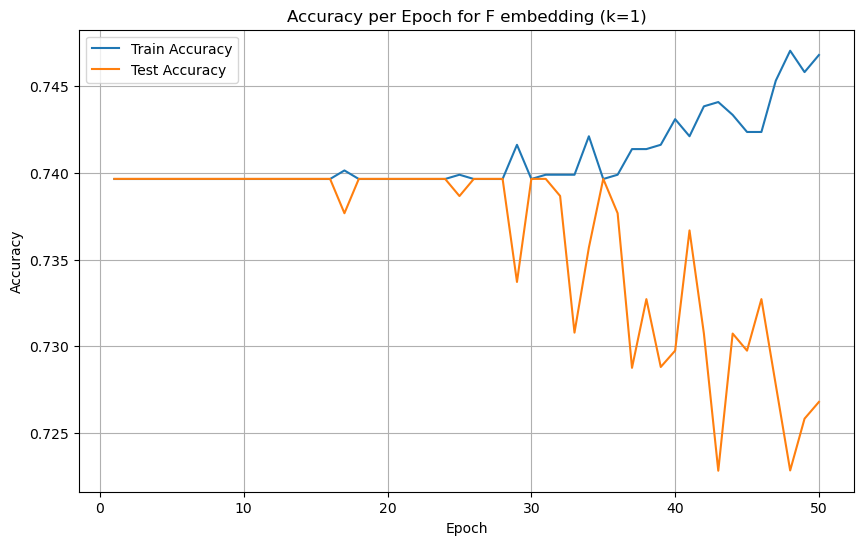

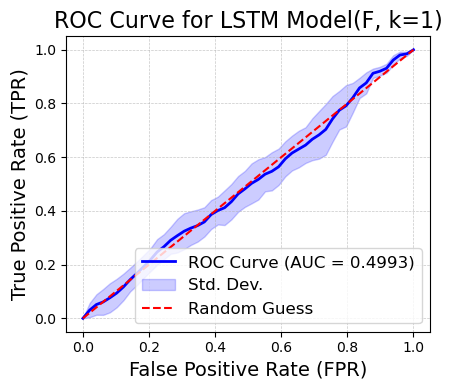

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4993
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 2=======================


5it [01:16, 15.29s/it]


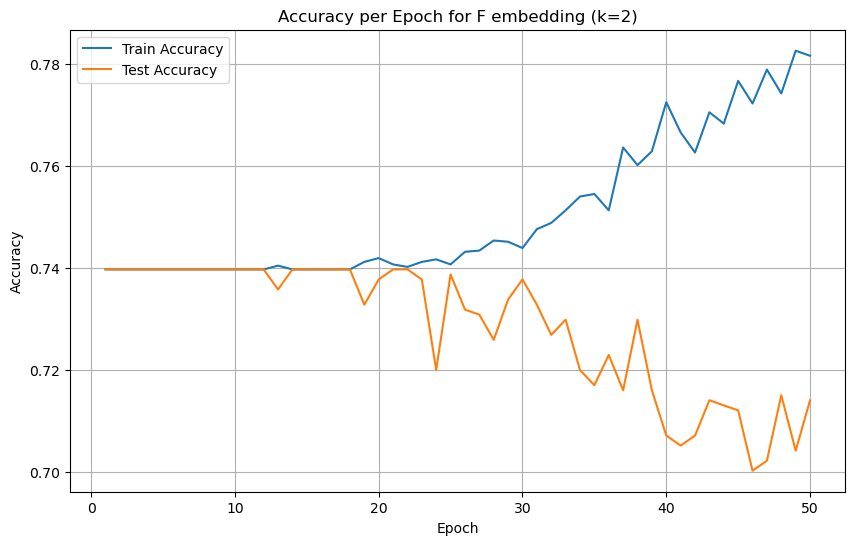

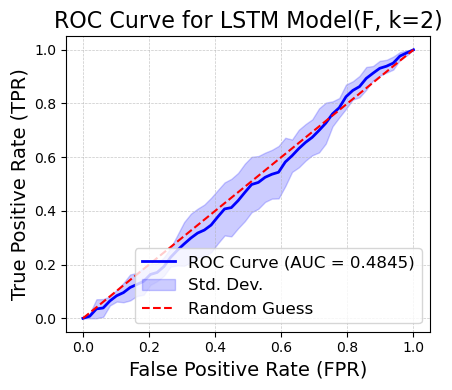

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4845
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 3=======================


5it [01:08, 13.61s/it]


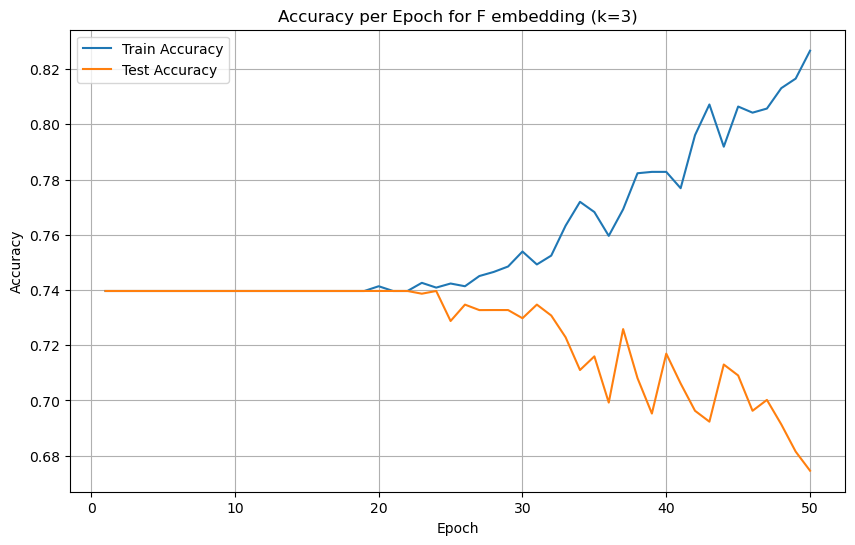

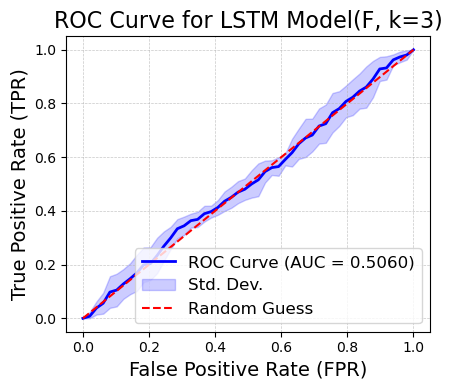

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5060
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 4=======================


5it [01:17, 15.43s/it]


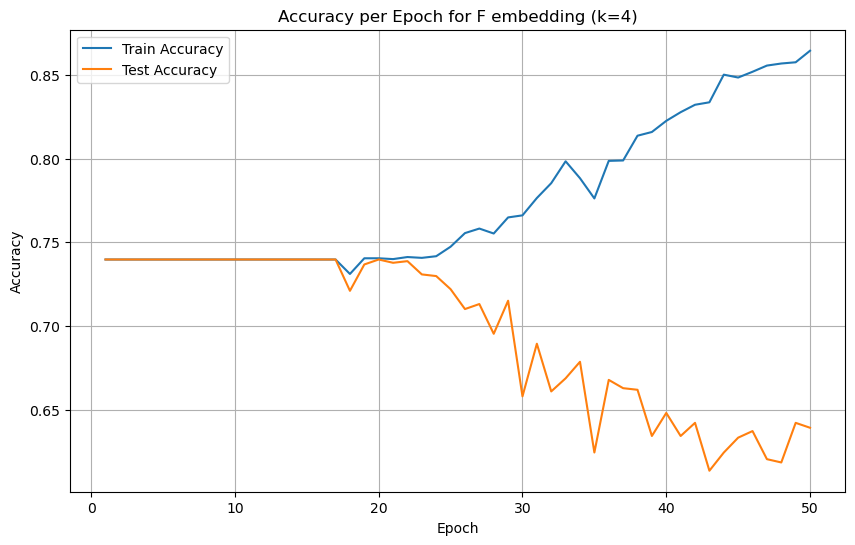

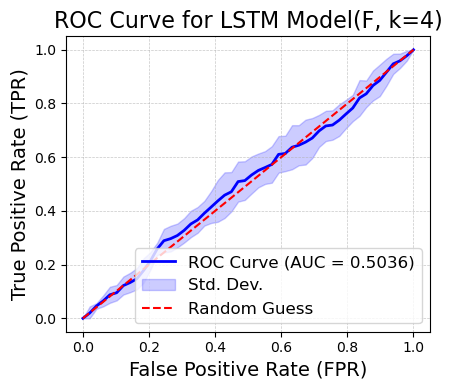

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5036
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 5=======================


5it [01:16, 15.38s/it]


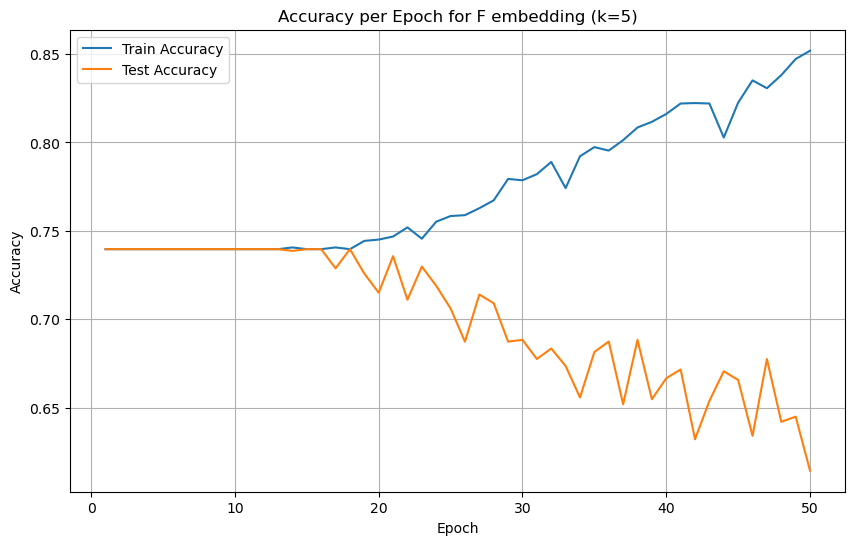

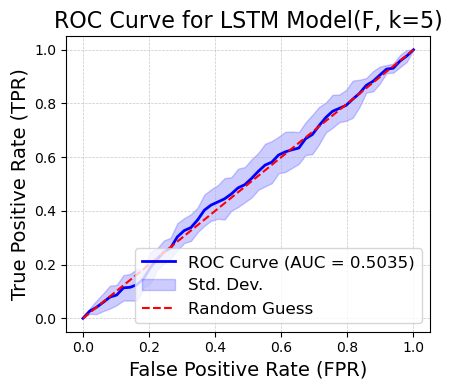

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5035
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 6=======================


5it [01:15, 15.19s/it]


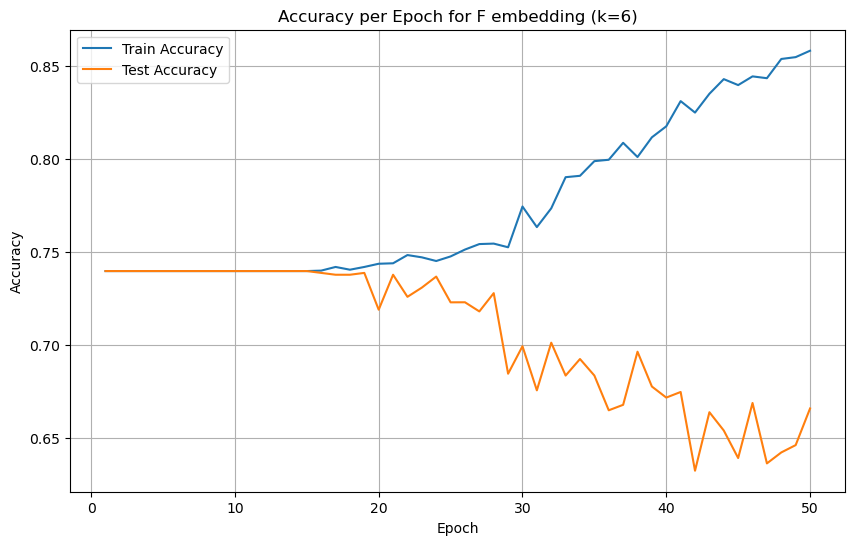

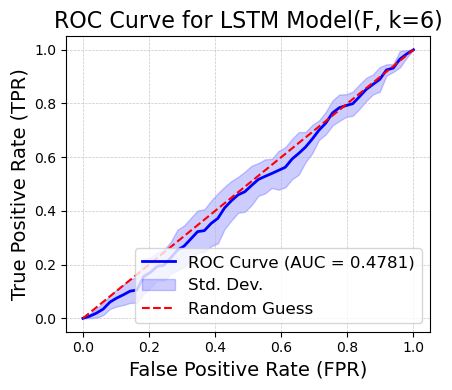

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4781
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 7=======================


5it [01:13, 14.70s/it]


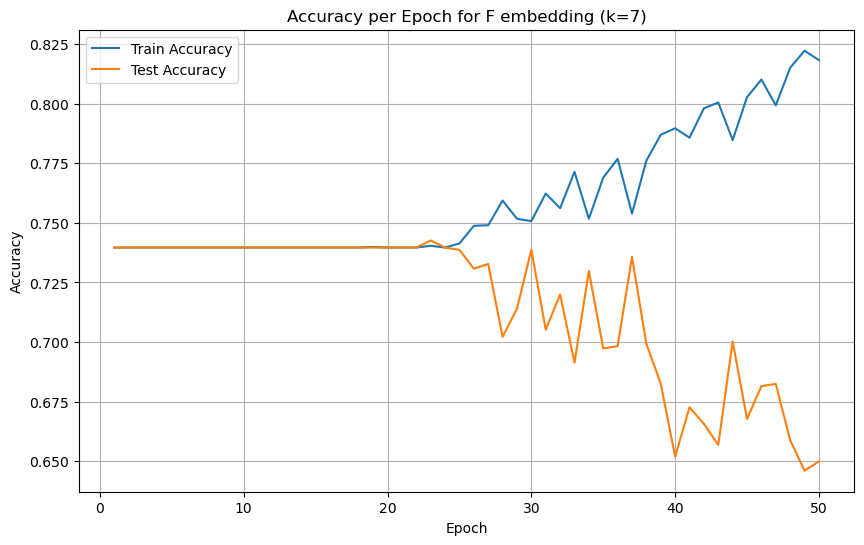

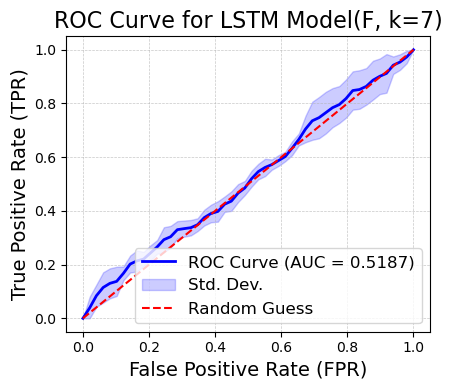

Epoch = 22
Best_mean_accuracy: 0.7426
Best mean_roc_auc: 0.5187
Best mean_precision: 0.1333
Best mean_recall: 0.0235
Best mean_npv: 0.7435
Best mean_specificity: 0.9960
==================For 8=======================


5it [01:18, 15.78s/it]


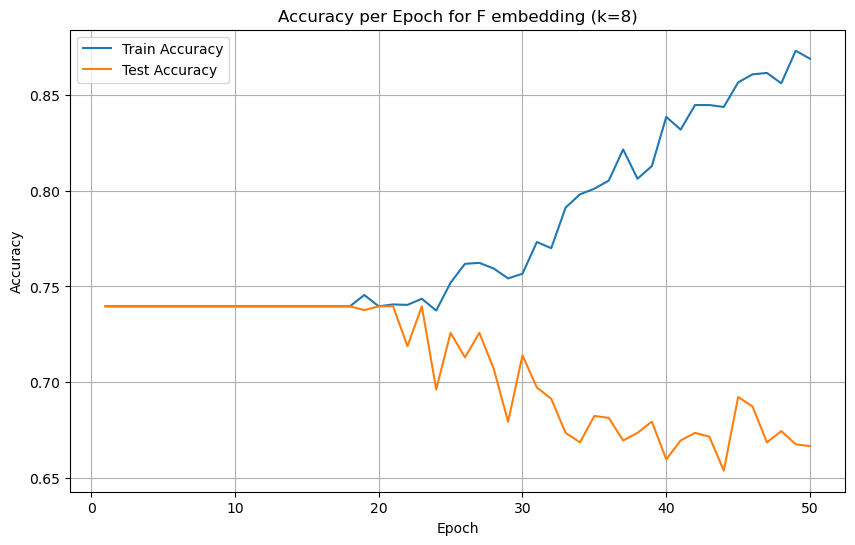

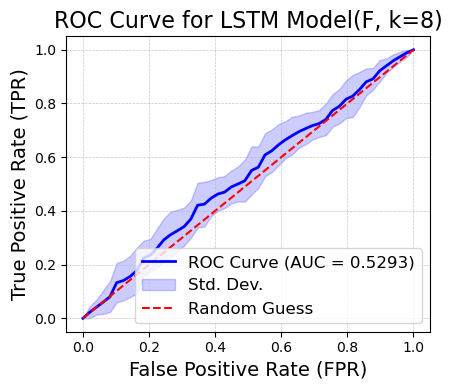

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5293
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 9=======================


5it [01:06, 13.39s/it]


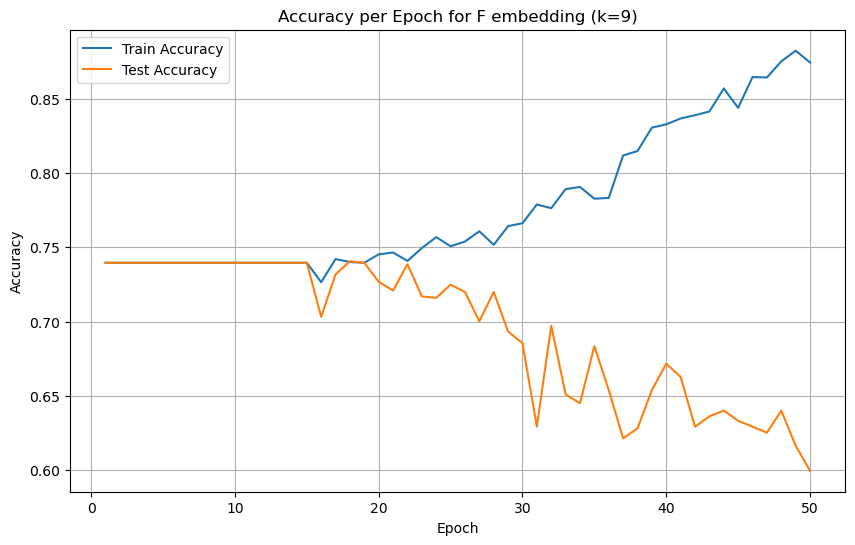

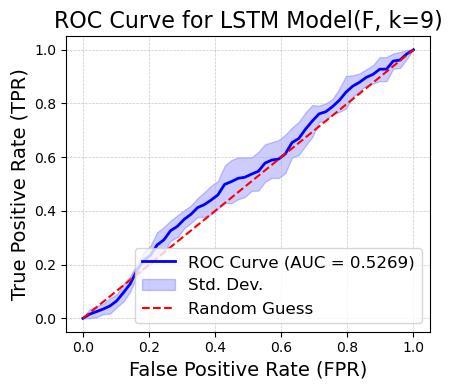

Epoch = 17
Best_mean_accuracy: 0.7406
Best mean_roc_auc: 0.5269
Best mean_precision: 0.2000
Best mean_recall: 0.0038
Best mean_npv: 0.7404
Best mean_specificity: 1.0000


In [10]:
input_dim = 3 * 5

for k in sorted(ks):
    print(f"==================For {k}=======================")
    splits = kf.split(dataset_F[k])

    train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
    precisions, recalls, npvs, specificities = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs, [0] * num_epochs

    epoch_fprs = [[] for _ in range(num_epochs)]
    epoch_tprs = [[] for _ in range(num_epochs)]
    mean_fpr = np.linspace(0, 1, 50)

    for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
        X_train, X_test = dataset_F[k][train_idx], dataset_F[k][test_idx]
        y_train, y_test = y[k][train_idx], y[k][test_idx]
        # print(f"Dataset: {len(X_train)} for train, {len(X_test)} for test")

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
        
        set_seed(42)
        model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p, seq_len = k).to(device)

        optimizer = optim.Adam(model.parameters(), lr = lr)


        for epoch in range(num_epochs):
            loss = train(model, train_loader, criterion, optimizer)
            train_acc = evaluate(model, train_loader)
            test_acc = evaluate(model, test_loader)
            fpr, tpr, _ = evaluate_with_auc(model, test_loader)
            precision = evaluate_with_fixed_threshold_precision(model, test_loader)
            recall = evaluate_with_fixed_threshold_recall(model, test_loader)
            npv = evaluate_with_npv(model, test_loader)
            specificity = evaluate_with_specificity(model, test_loader)

            train_accs[epoch] += train_acc
            test_accs[epoch] += test_acc
            precisions[epoch] += precision
            recalls[epoch] += recall
            npvs[epoch] += npv
            specificities[epoch] += specificity

            epoch_fprs[epoch].append(fpr)
            epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
            epoch_tprs[epoch][-1][0] = 0.0  

    mean_train_accs = [acc / K for acc in train_accs]
    mean_test_accs = [acc / K for acc in test_accs]
    mean_precisions = [pre / K for pre in precisions]
    mean_recalls = [recall / K for recall in recalls]
    mean_npvs = [npv / K for npv in npvs]
    mean_specificities = [spec / K for spec in specificities]

    best_mean_accuracy = max(mean_test_accs)
    best_epoch = mean_test_accs.index(best_mean_accuracy)
    mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
    std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
    mean_tpr[-1] = 1.0
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    # Plot accuracy graphs over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch for F embedding (k={k})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC Curve for the best epoch
    plt.figure(figsize=(4.5, 4))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
    plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'ROC Curve for LSTM Model(F, k={k})', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    plt.show()
        
    print(f"Epoch = {best_epoch}")
    print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
    print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
    print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
    print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")
    print(f"Best mean_npv: {mean_npvs[best_epoch]:.4f}")
    print(f"Best mean_specificity: {mean_specificities[best_epoch]:.4f}")

### Function Type and Arguments (F+A)

==================For 1=======================


5it [01:17, 15.51s/it]


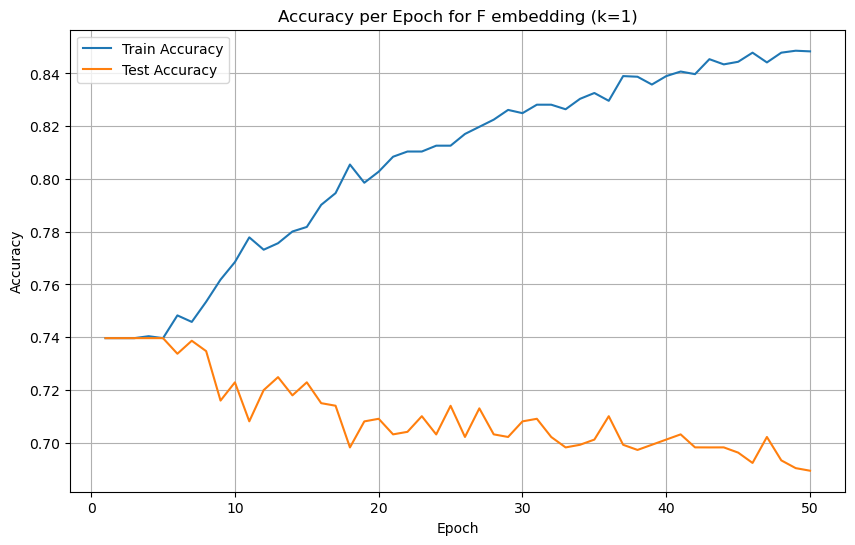

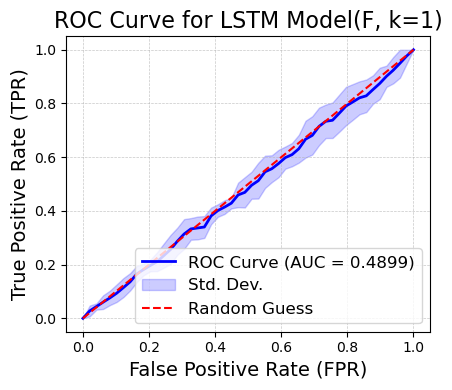

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4899
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 2=======================


5it [01:14, 14.94s/it]


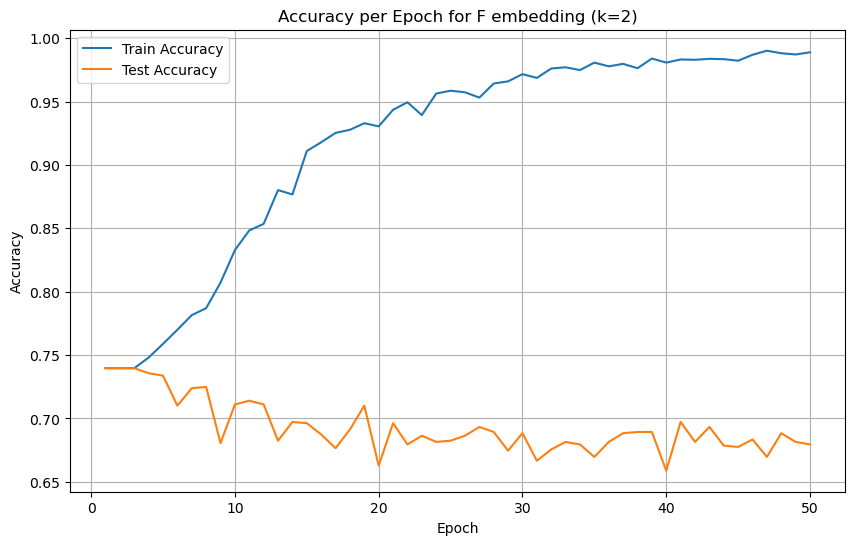

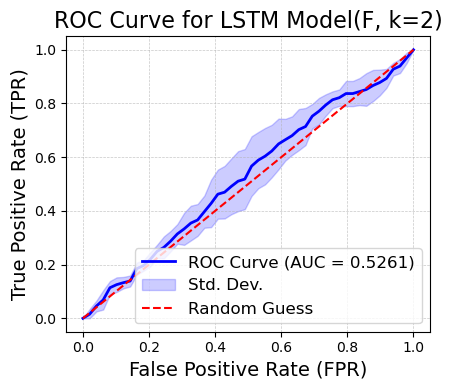

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5261
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 3=======================


5it [01:18, 15.74s/it]


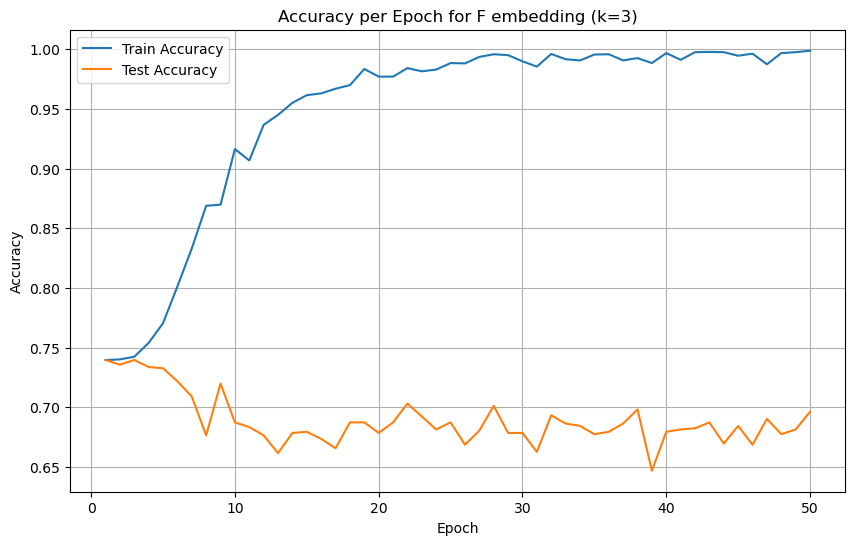

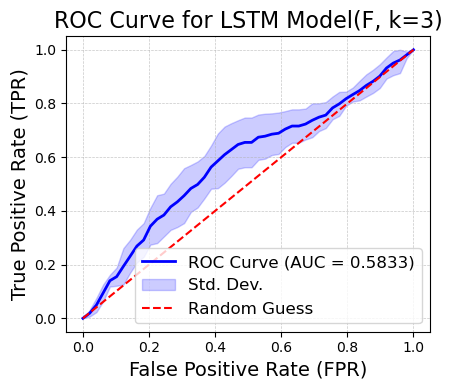

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5833
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 4=======================


5it [01:18, 15.61s/it]


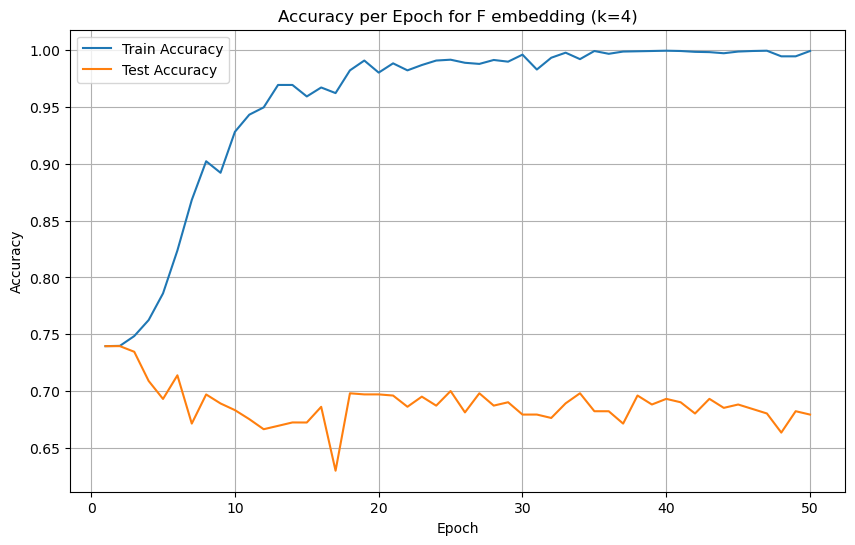

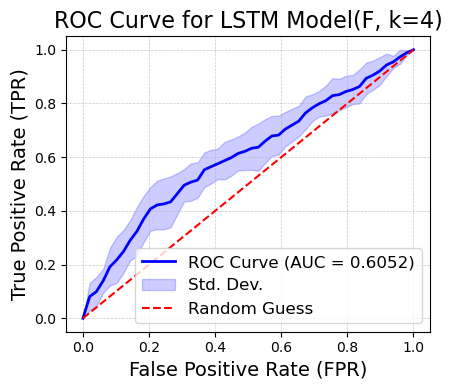

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.6052
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 5=======================


5it [01:18, 15.64s/it]


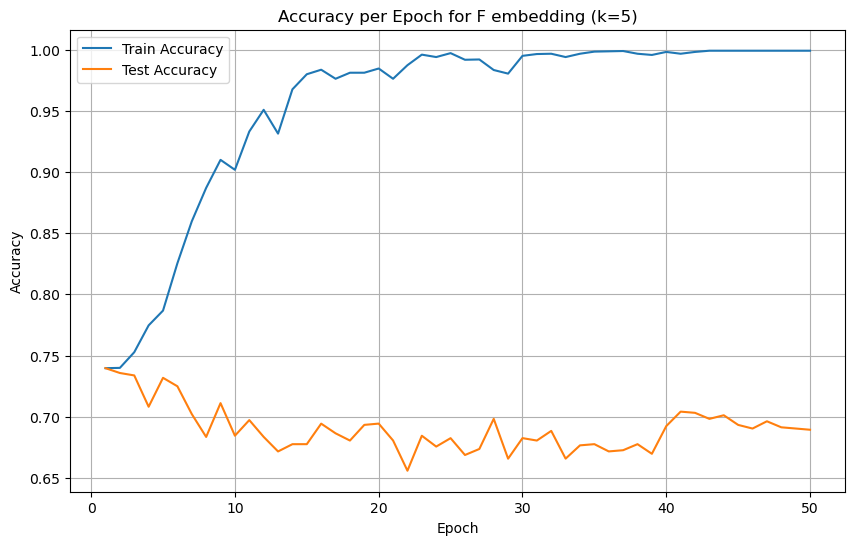

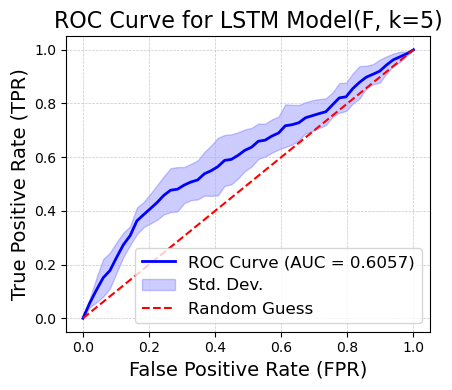

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.6057
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 6=======================


5it [01:15, 15.18s/it]


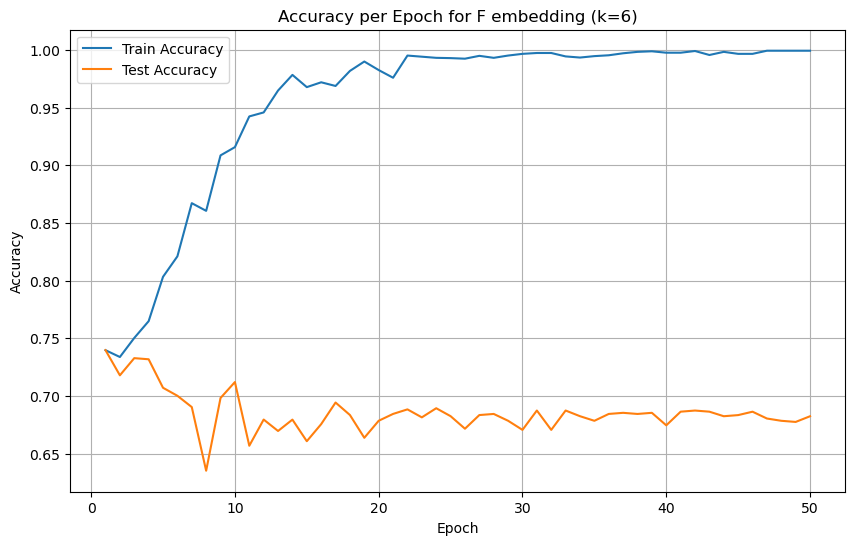

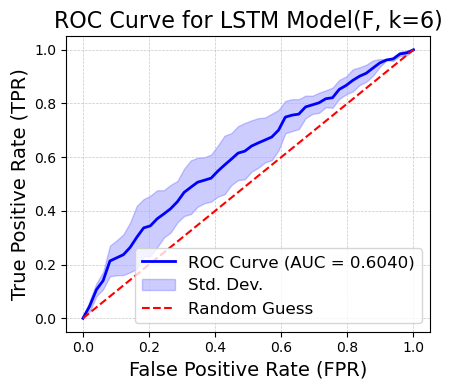

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.6040
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 7=======================


5it [01:16, 15.25s/it]


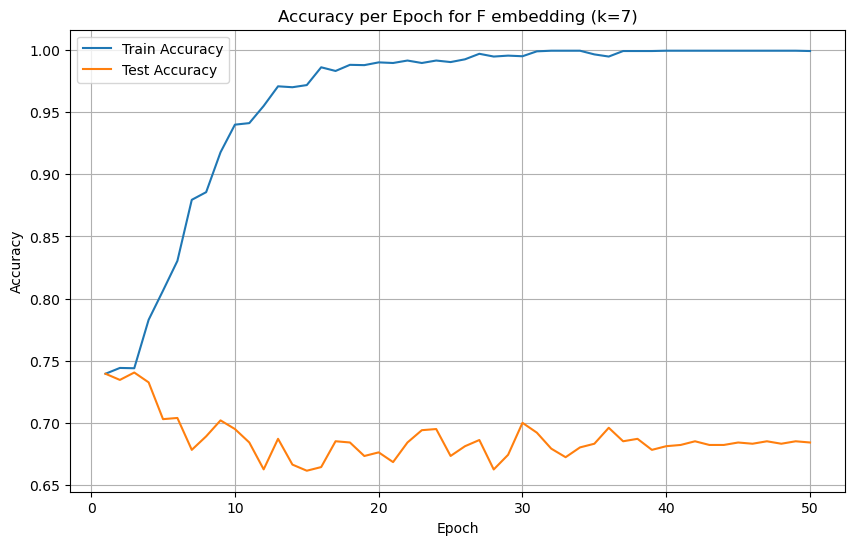

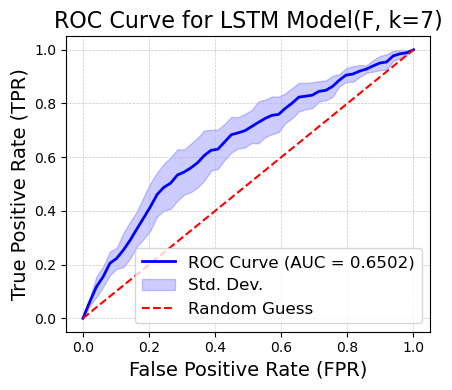

Epoch = 2
Best_mean_accuracy: 0.7406
Best mean_roc_auc: 0.6502
Best mean_precision: 0.2067
Best mean_recall: 0.0319
Best mean_npv: 0.7442
Best mean_specificity: 0.9891
==================For 8=======================


5it [01:12, 14.51s/it]


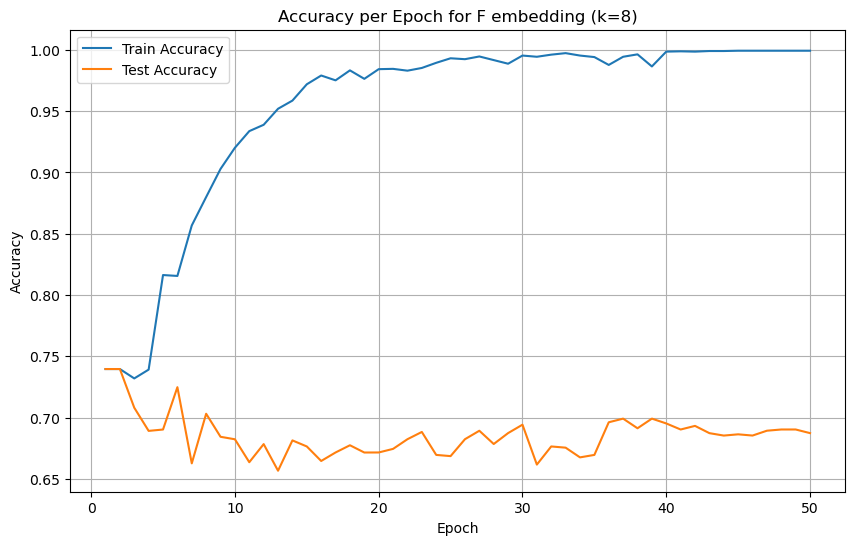

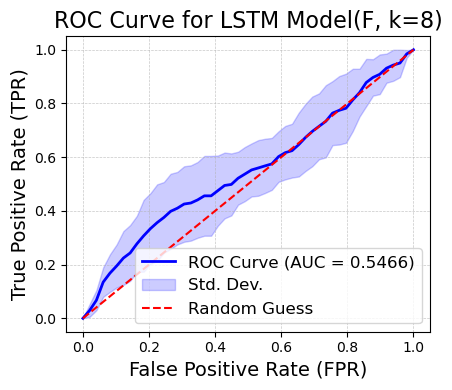

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5466
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 9=======================


5it [01:09, 13.90s/it]


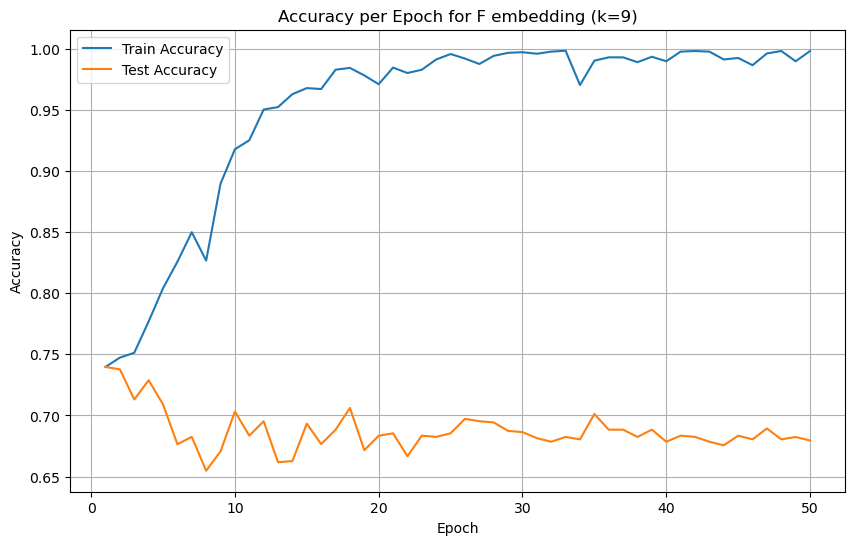

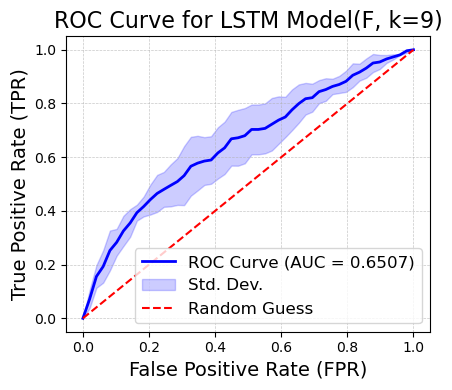

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.6507
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000


In [11]:
input_dim = 51 * 5

for k in sorted(ks):
    print(f"==================For {k}=======================")
    splits = kf.split(dataset_FA[k])

    train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
    precisions, recalls, npvs, specificities = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs, [0] * num_epochs

    epoch_fprs = [[] for _ in range(num_epochs)]
    epoch_tprs = [[] for _ in range(num_epochs)]
    mean_fpr = np.linspace(0, 1, 50)

    for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
        X_train, X_test = dataset_FA[k][train_idx], dataset_FA[k][test_idx]
        y_train, y_test = y[k][train_idx], y[k][test_idx]
        # print(f"Dataset: {len(X_train)} for train, {len(X_test)} for test")

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
        
        set_seed(42)
        model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p, seq_len = k).to(device)

        optimizer = optim.Adam(model.parameters(), lr = lr)


        for epoch in range(num_epochs):
            loss = train(model, train_loader, criterion, optimizer)
            train_acc = evaluate(model, train_loader)
            test_acc = evaluate(model, test_loader)
            fpr, tpr, _ = evaluate_with_auc(model, test_loader)
            precision = evaluate_with_fixed_threshold_precision(model, test_loader)
            recall = evaluate_with_fixed_threshold_recall(model, test_loader)
            npv = evaluate_with_npv(model, test_loader)
            specificity = evaluate_with_specificity(model, test_loader)

            train_accs[epoch] += train_acc
            test_accs[epoch] += test_acc
            precisions[epoch] += precision
            recalls[epoch] += recall
            npvs[epoch] += npv
            specificities[epoch] += specificity

            epoch_fprs[epoch].append(fpr)
            epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
            epoch_tprs[epoch][-1][0] = 0.0  

    mean_train_accs = [acc / K for acc in train_accs]
    mean_test_accs = [acc / K for acc in test_accs]
    mean_precisions = [pre / K for pre in precisions]
    mean_recalls = [recall / K for recall in recalls]
    mean_npvs = [npv / K for npv in npvs]
    mean_specificities = [spec / K for spec in specificities]

    best_mean_accuracy = max(mean_test_accs)
    best_epoch = mean_test_accs.index(best_mean_accuracy)
    mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
    std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
    mean_tpr[-1] = 1.0
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    # Plot accuracy graphs over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch for F embedding (k={k})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC Curve for the best epoch
    plt.figure(figsize=(4.5, 4))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
    plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'ROC Curve for LSTM Model(F, k={k})', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    plt.show()
        
    print(f"Epoch = {best_epoch}")
    print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
    print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
    print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
    print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")
    print(f"Best mean_npv: {mean_npvs[best_epoch]:.4f}")
    print(f"Best mean_specificity: {mean_specificities[best_epoch]:.4f}")